In [2]:
%load_ext autoreload
%autoreload 2
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../../timeseries/')
sys.path.append('../../src/')
from linear_ssm import StateSpace_EM
from heteroscedastic_ssm import HeteroscedasticKalmanSmoother, HeteroscedasticStateSpace_EM

In [3]:
import factors, densities

In [4]:
def proj(U, v):
    return numpy.dot(numpy.dot(v, U) / numpy.linalg.norm(U, axis=0), U.T)

def gs(N):
    V = numpy.zeros((N, N))
    A = numpy.random.randn(N,N)
    #A = numpy.eye(N)
    for d in range(N):
        v = A[:,d]
        V[:,d] = v - proj(V[:,:d], v)
        V[:,d] /= numpy.sqrt(numpy.sum(V[:,d] ** 2))
    return V


def generate_heteroscedastic_data(T, Dx, Dz, Du, sigma_z = .02, sigma_x = .02):
    params_dict = {'T': T, 'Dx': Dx, 'Dz': Dz, 'Du': Du, 'sigma_z': sigma_z, 'sigma_x': sigma_x}
    C = numpy.random.randn(Dx, Dz)
    C /= numpy.sum(C, axis=0)[None] * .5
    U = gs(Dx)[:Du].T
    w = 3 * numpy.random.randn(Du, Dz)
    #w /=  numpy.sum(numpy.abs(w), axis=1)[:,None]
    b_w = numpy.random.randn(Du)
    beta = 1e-2 * numpy.random.rand(Du)
    params_dict = {**params_dict, 'C': C, 'U': U, 'w': w, 'b_w': b_w, 'beta': beta}
    
    # Sample latent space
    z = numpy.zeros([Dz, T])
    noise_z = sigma_z * numpy.random.randn(Dz, T)
    # A = .99 * numpy.eye(Dz)
    # A[1,0] = .05
    # A[0,1] = -.05
    # b = numpy.zeros(Dz)
    # for t in range(1,T):
    #     z[:,t] = numpy.dot(A, z[:,t-1]) + b + noise_z[:,t-1]
    freq = 1 / (1000 * numpy.random.rand(Dz) + 500)
    phase = 2 * numpy.pi * numpy.random.rand(Dz)
    for idz in range(Dz): 
        z[idz] = 1*numpy.cos(2 * numpy.pi * numpy.arange(T) * freq[idz] + phase[idz]) + noise_z[idz]
    D_Sigma = 2 * beta[:,None] * numpy.cosh(numpy.dot(w, z) + b_w[:,None])
    x = numpy.zeros((Dx,T))
    mu_x = numpy.dot(C, z)
    noise_x = numpy.random.randn(Dx, T)
    for t in range(T):
        Sigma_x = sigma_x ** 2 * numpy.eye(Dx) + numpy.dot(numpy.dot(U, numpy.diag(D_Sigma[:,t])), U.T)
        L_x = numpy.linalg.cholesky(Sigma_x)
        x[:,t] = mu_x[:,t] + numpy.dot(L_x, noise_x[:,t])
    return x.T, z.T, params_dict

Text(0, 0.5, 'z1')

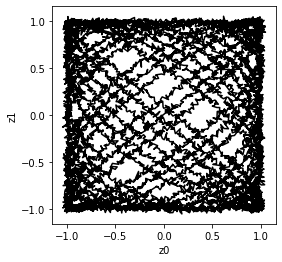

In [113]:
Dz = 2
Dx = 10
Du = 4
T = 10000
X, z, params_dict = generate_heteroscedastic_data(T, Dx, Dz, Du)
pyplot.figure(figsize=(4,4))
pyplot.plot(z[:,0], z[:,1], 'k')
pyplot.xlabel('z0')
pyplot.ylabel('z1')

Text(0, 0.5, 'X1')

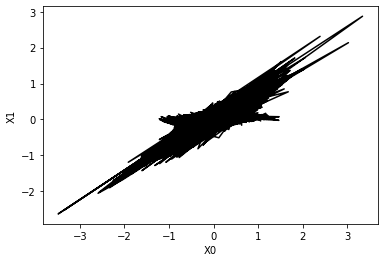

In [114]:
pyplot.plot(X[:,1], X[:,7], 'k')
pyplot.xlabel('X0')
pyplot.ylabel('X1')

(0.0, 5000.0)

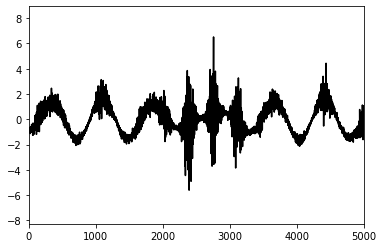

In [115]:
pyplot.plot(X[:,0], 'k')
pyplot.xlim([0,5000])

In [8]:
A, b = numpy.eye(Dz), numpy.zeros(Dz)
C = params_dict['C']
d = numpy.zeros(Dx)
Qz = params_dict['sigma_z'] ** 2 * numpy.eye(Dz)
sigma_x = params_dict['sigma_x']
U = params_dict['U'][:,:]
W = numpy.vstack([params_dict['b_w'], params_dict['w'].T])
beta = params_dict['beta']
hks = HeteroscedasticKalmanSmoother(X, A, b, Qz, C, d, U, W, beta, sigma_x)
hks.forward_path()
hks.backward_path()

In [336]:
U.shape, params_dict['w'].shape

((4, 2), (2, 2))

In [337]:
hks.exp_h_minus.nu, W[1:].T

(array([[ 1.58894371,  1.55728912],
        [ 5.02393149, -0.56861271]]),
 array([[-1.58894371, -1.55728912],
        [-5.02393149,  0.56861271]]))

In [9]:
p_x = hks.compute_data_density()
mu_x = p_x.mu
std_x = 1.68 * numpy.sqrt(p_x.Sigma.diagonal(axis1=1,axis2=2))

(-10.0, 10.0)

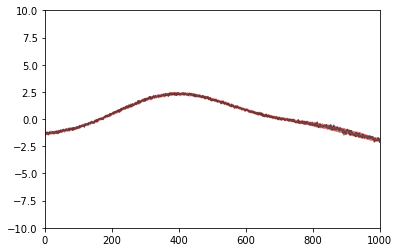

In [10]:
#pyplot.plot(p_x.mu[:,0])
#pyplot.plot(X[0].T)
i = 0
pyplot.plot(X[:,i], 'k', alpha=.5)
pyplot.fill_between(numpy.arange(T), mu_x[:,i] - std_x[:,i], mu_x[:,i] + std_x[:,i], alpha=.5, color='C3')
pyplot.xlim([0,1000])
pyplot.ylim([-10,10])

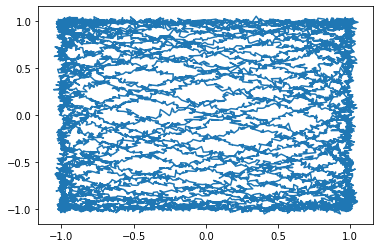

In [11]:
pyplot.plot(hks.smoothing_density.mu[:,0],hks.smoothing_density.mu[:,1])

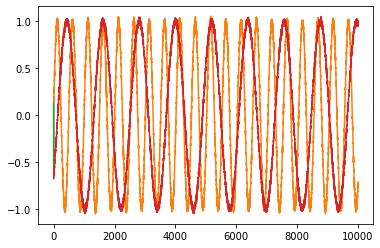

In [12]:
pyplot.plot(z.T[:,0])
pyplot.plot(hks.smoothing_density.mu[:,0])
pyplot.plot(z.T[:,1])
pyplot.plot(hks.smoothing_density.mu[:,1])

In [68]:
lssm = StateSpace_EM(X, Dz=2)
lssm.run_em()

Iteration 1 - llk=-3852784.3
Iteration 2 - llk=160634.3
Iteration 3 - llk=167183.3
Iteration 4 - llk=173258.9
Iteration 5 - llk=178621.5
Iteration 6 - llk=182960.2
Iteration 7 - llk=186078.2
Iteration 8 - llk=188019.5
Iteration 9 - llk=189059.6
Iteration 10 - llk=189561.3
Iteration 11 - llk=189809.2
Iteration 12 - llk=189953.5
Iteration 13 - llk=190052.7
Iteration 14 - llk=190126.3
Iteration 15 - llk=190181.9
Iteration 16 - llk=190223.6
Iteration 17 - llk=190254.7
Iteration 18 - llk=190277.5
Iteration 19 - llk=190294.3


[-3852784.2782192715,
 160634.332882865,
 167183.2563201189,
 173258.87685867102,
 178621.46741377274,
 182960.18609932958,
 186078.1507083682,
 188019.45876473392,
 189059.62836236274,
 189561.29293542157,
 189809.2408093229,
 189953.53752433838,
 190052.66726930597,
 190126.27900404515,
 190181.85476502494,
 190223.5988593208,
 190254.6548016386,
 190277.5472062906,
 190294.2867931455]

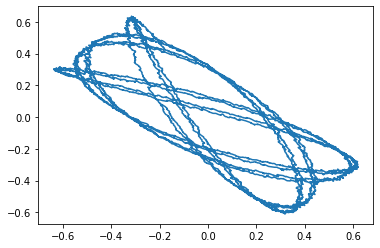

In [69]:
pyplot.plot(lssm.ks.smoothing_density.mu[:,0], lssm.ks.smoothing_density.mu[:,1])

In [93]:
lssm.Qz

array([[ 0.00069629, -0.0003234 , -0.00053962],
       [-0.0003234 ,  0.00034525,  0.00015682],
       [-0.00053962,  0.00015682,  0.00061844]])

In [126]:
mu_x = (numpy.dot(lssm.C, lssm.ks.smoothing_density.mu.T) + lssm.d[:,None]).T
cov = numpy.dot(X - mu_x[1:].T,X.T - mu_x[1:])
eigvals, eigvecs = numpy.linalg.eig(cov)
U = eigvecs[:,:3]

0.02

In [116]:
hssm = HeteroscedasticStateSpace_EM(X, Dz=2, Du=4, noise_x=1., noise_z=.1)
#hssm.Qz = lssm.Qz# * 1e-2
#hssm.A, hssm.b = lssm.A, lssm.b
#hssm.C, hssm.d = lssm.C, lssm.d
#hssm.U = params_dict['U']
#hssm.W = numpy.vstack([params_dict['b_w'], params_dict['w'].T])
#hssm.beta = params_dict['beta']
#hssm.sigma_x = params_dict['sigma_x']
#hssm.ks = HeteroscedasticKalmanSmoother(X.T, hssm.A, hssm.b, hssm.Qz, hssm.C, hssm.d, hssm.U, hssm.W, hssm.beta, hssm.sigma_x)
#hssm.Qz_inv, hssm.ln_det_Qz = hssm.ks.state_density.Lambda[0], hssm.ks.state_density.ln_det_Sigma[0]
#hssm.W[:] = 0

In [ ]:
hssm.W[:] = 1e-10 * numpy.random.randn(*hssm.W.shape)
llk_list = hssm.run_em(conv_crit=1e-5)

0.5438284870933262
1.0078387987075739
5.44942295981087
[[ 1.00000000e+00  9.65110150e-16 -5.65092664e-16  1.47147878e-15]
 [ 9.65110150e-16  1.00000000e+00 -4.01913932e-16  2.53318582e-16]
 [-5.65092664e-16 -4.01913932e-16  1.00000000e+00 -8.20398420e-17]
 [ 1.47147878e-15  2.53318582e-16 -8.20398420e-17  1.00000000e+00]]
Iteration 1 - llk=-109845.9
0.07693843537564621
5.619089494200268
5.625335347883059
5.62560651970068
[[ 1.00000000e+00  7.57257711e-14  8.24837325e-16  2.38685698e-14]
 [ 7.57257711e-14  1.00000000e+00  6.97025651e-14 -2.95766204e-15]
 [ 8.24837325e-16  6.97025651e-14  1.00000000e+00  7.78895831e-15]
 [ 2.38685698e-14 -2.95766204e-15  7.78895831e-15  1.00000000e+00]]
Iteration 2 - llk=-76422.8
0.05831518005309475
5.5881532388165684
5.6001529120895315
5.600334967195051
[[ 1.00000000e+00 -4.97541277e-13 -9.89746276e-15  1.00530240e-13]
 [-4.97541277e-13  1.00000000e+00  8.91988638e-13  1.17903618e-14]
 [-9.89746276e-15  8.91988638e-13  1.00000000e+00  2.35941707e-14]
 [

In [88]:
hssm.W, hssm.sigma_x, numpy.log(hssm.beta)

(array([[  0.28771796,   0.18326185,  -1.13862556,  -0.37495012],
        [ -0.37307995,  -4.26386177,   2.22991874,   0.60988887],
        [ 21.48063481,  12.92620672,  14.11275559, -44.27470831]]),
 0.020669317721442353,
 array([-5.21418206, -6.13334186, -4.78968467, -4.699724  ]))

In [85]:
params_dict['w']

array([[ 0.81811669, -0.18140235],
       [-1.59923462,  1.53142064],
       [ 5.32534415,  0.18298448],
       [-1.74686888, -2.94821522]])

In [12]:
numpy.dot(hssm.U.T, hssm.U)

array([[1.00000000e+00, 3.86812772e-14],
       [3.86812772e-14, 1.00000000e+00]])

In [72]:
phi = hssm.ks.smoothing_density.slice(range(1,hssm.T+1))
numpy.amax(hssm.get_lb_i(0, phi, update='C')[0])

4.0723286514889825 0.010047026561544927


0.7544703967834469

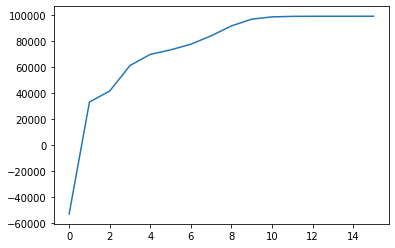

In [98]:
pyplot.plot(llk_list[1:])

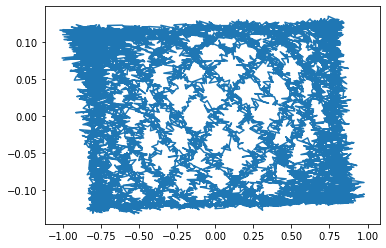

In [99]:
pyplot.plot(hssm.ks.smoothing_density.mu[:,0], hssm.ks.smoothing_density.mu[:,1])
#pyplot.plot(hssm.ks.smoothing_density.mu[:,1])

In [99]:
hssm.sigma_x, hssm.Qz

(0.01831563888873418,
 array([[ 0.00360892, -0.0001068 ],
        [-0.0001068 ,  0.00043705]]))

In [54]:
eig_vals, eig_vecs = numpy.linalg.eig(numpy.dot((hssm.ks.X - mu_x).T, (hssm.ks.X - mu_x)))
#hssm.U = eig_vecs[:,:2]
eig_vals
#numpy.dot(eig_vecs[:,:2].T, eig_vecs[:,:2])

array([7.05384775e+03, 2.59272448e+03, 9.04207309e+02, 4.34488118e+02,
       2.30761981e+02, 9.90013140e+01, 3.88989147e+00, 3.96016994e+00,
       4.12923478e+00, 4.06073200e+00])

In [143]:
numpy.dot(hssm.U.T, params_dict['U'])

array([[ 0.05384709,  0.99821694],
       [ 0.99852967, -0.05375583],
       [-0.00319196,  0.01293048]])

In [100]:
p_x = hssm.ks.compute_data_density()
mu_x = p_x.mu
std_x = 1.68 * numpy.sqrt(p_x.Sigma.diagonal(axis1=1,axis2=2))

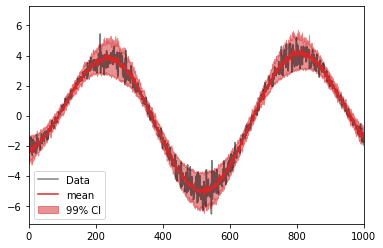

In [112]:
#pyplot.plot(p_x.mu[:,0])
#pyplot.plot(X[0].T)
i = 9
pyplot.plot(X[:,i], 'k', alpha=.5, label='Data')
pyplot.fill_between(numpy.arange(T), mu_x[:,i] - std_x[:,i], mu_x[:,i] + std_x[:,i], alpha=.5, color='C3', label='99% CI')
pyplot.plot(mu_x[:,i], 'C3', label='mean')
pyplot.xlim([0,1000])
pyplot.legend()

## import scipy
self = hssm
self.d = numpy.mean(X.T, axis=0)
self.C = scipy.linalg.eigh(numpy.dot((X.T-self.d[None]).T, X.T-self.d[None]), eigvals=(self.Dx-self.Dz, self.Dx-1))[1]
numpy.linalg.solve(self.C, X.T - self.d)

In [86]:
z_hat = numpy.dot(numpy.linalg.pinv(self.C), (X.T - self.d).T).T
delta_X = X.T - numpy.dot(z_hat, self.C.T) - self.d
cov = numpy.dot(delta_X.T, delta_X)

In [109]:
hssm.sigma_x ** 2, hssm.W, hssm.beta

(nan,
 array([[nan, nan],
        [nan, nan],
        [nan, nan]]),
 array([nan, nan]))

In [497]:
hssm.beta, hssm.sigma_x, hssm.Qz

(array([0.11233714]),
 2.791265397606464,
 array([[ 1.10786445e-04, -2.32292766e-05],
        [-2.32292766e-05,  1.61731322e-04]]))

In [498]:
x0 = hssm.W.flatten()
x1 = numpy.copy(x0) #+ 1e-8 
x1[1] += 1e-8

In [499]:
Q0, grad = hssm.parameter_optimization_W(x0)
Q1 = hssm.parameter_optimization_W(x1)[0]
(Q1 - Q0) / 1e-8, grad[1] * hssm.T

-24379.843239887967
-24379.843239887967


(0.0, nan)

In [500]:
x0

array([0., 0., 0.])

In [501]:
minimize(hssm.parameter_optimization_W, x0, jac=True, method='L-BFGS-B')

-24379.843239887967
nan
nan
nan
nan


KeyboardInterrupt: 

In [298]:
x0 = numpy.log(hssm.beta)
x1 = x0 + 1e-8 
Q0, grad = hssm.parameter_optimization_beta(x0)
Q1 = hssm.parameter_optimization_beta(x1)[0]
(Q1 - Q0) / 1e-8, grad

(34.814365790225565, array([[34.81393004]]))

In [147]:
minimize(hssm.parameter_optimization_beta, x0, jac=True, method='L-BFGS-B')

      fun: 34630.20027339205
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([[3.93603691e-05]])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 19
      nit: 18
     njev: 19
   status: 0
  success: True
        x: array([-12.7146429])

In [132]:
x0 = numpy.array([numpy.log(hssm.sigma_x ** 2)])
x1 = x0 + 1e-8 
Q0, grad = hssm.parameter_optimization_sigma(x0)
Q1 = hssm.parameter_optimization_sigma(x1)[0]
(Q1 - Q0) / 1e-8, grad

-21102.80889477962
-21102.808896235798


(145.6177415093407, array([[145.44429259]]))

In [133]:
from scipy.optimize import minimize
minimize(hssm.parameter_optimization_sigma, x0, jac=True, method='L-BFGS-B')

-21102.80889477962
-22374.26249419866
-21101.2346840593
-21099.846121642637
-21337.315814347923
-21098.566150424245
-21097.79988134363
-21149.88043058451
-21097.63114115329
-21097.999809971465
-21097.658908453737
-21097.63114115329
-3.752469839800744e+110
-21097.63114115329


      fun: 21097.63114115329
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([[246.86866191]])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 14
      nit: 2
     njev: 14
   status: 0
  success: True
        x: array([-0.07371172])

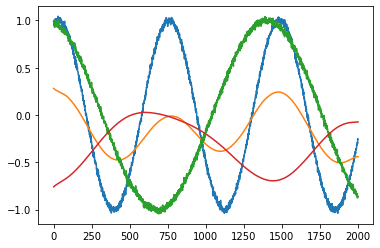

In [10]:
pyplot.plot(z.T[:,0])
pyplot.plot(hssm.ks.smoothing_density.mu[:,0])
pyplot.plot(z.T[:,1])
pyplot.plot(hssm.ks.smoothing_density.mu[:,1])

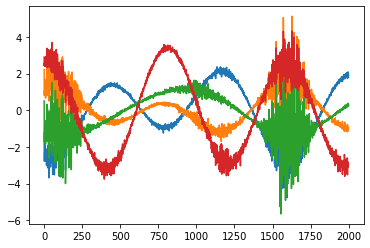

In [316]:
pyplot.plot(X.T)

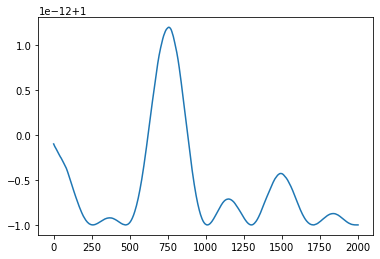

In [29]:
pyplot.plot(numpy.cosh(numpy.dot(hssm.ks.smoothing_density.mu, hssm.W[1:]) + hssm.W[0]))

In [30]:
hssm.C, hssm.b, hssm.A, hssm.W, hssm.beta, hssm.sigma_x

(array([[-1.74357482,  0.1522161 ],
        [-0.58345997,  1.04354838],
        [-3.47574423,  2.11714086],
        [-0.46752664,  0.39023293]]),
 array([ 0.00034887, -0.00030819]),
 array([[ 1.00000000e+00, -2.06665765e-16],
        [ 0.00000000e+00,  1.00000000e+00]]),
 array([[-5.56935538e-07],
        [ 5.10644122e-06],
        [ 3.62148789e-06]]),
 array([0.08081108]),
 0.08227159889986435)

In [240]:
numpy.linalg.LinAlgError

array([0., 0.])

In [258]:
self = hssm
phi = self.ks.smoothing_density.slice(range(1,self.T+1))
intD_inv_z, intD_inv_zz = numpy.zeros((self.Du, self.T, self.Dz)), numpy.zeros((self.Du, self.Dz, self.Dz))
for iu in range(self.Du):
    intD_inv_z_i, intD_inv_zz_i = self.get_lb_i(iu, phi, update='C')
    intD_inv_z[iu] = intD_inv_z_i
    intD_inv_zz[iu] += numpy.sum(intD_inv_zz_i, axis=0)
Ez = phi.integrate('x')
Ezz = numpy.sum(phi.integrate('xx'), axis=0)
Ezx_d = numpy.einsum('ab,ac->bc', Ez, self.ks.X - self.d)
UU = numpy.einsum('ab,cb->bac', self.U, self.U)
intD_inv_zx_d = numpy.einsum('abc,bd->adc', intD_inv_z, self.ks.X - self.d)

In [259]:
def Q_C_func(params):
    C = numpy.reshape(params, (self.Dx, self.Dz))
    tr_CEzx_d = numpy.trace(numpy.dot(C, Ezx_d))
    tr_CC_Ezz = numpy.trace(numpy.dot(numpy.dot(C.T, C), Ezz))
    tr_uu_CC_Dinv_zx_d = numpy.sum(numpy.trace(numpy.einsum('abc,acd->abd', UU, numpy.einsum('ab,cdb->cad', C, intD_inv_zx_d)), axis1=1, axis2=2))
    CD_inv_zz = numpy.einsum('ab,cbd->cad', C, intD_inv_zz)
    CD_inv_zzC = numpy.einsum('abc,dc->abd', CD_inv_zz, C)
    uCD_inv_zzCu = numpy.sum(numpy.einsum('ab,ba->b',self.U, numpy.einsum('abc,ca->ab', CD_inv_zzC, self.U)))
    Q_C = 2 * tr_CEzx_d - tr_CC_Ezz - 2 * tr_uu_CC_Dinv_zx_d + uCD_inv_zzCu #- 2 * tr_uu_CC_Dinv_zx_d + uCD_inv_zzCu
    Q_C /= 2 * self.sigma_x ** 2
    C_Ezz = numpy.dot(C, Ezz)
    UU_C_Dinv_zz = numpy.sum(numpy.einsum('abc,abd->acd', UU, CD_inv_zz), axis=0)
    UU_Dinv_zx_d = numpy.sum(numpy.einsum('abc,abd->acd', UU, intD_inv_zx_d), axis=0)
    dQ_C = Ezx_d.T - UU_Dinv_zx_d + UU_C_Dinv_zz - C_Ezz #- UU_Dinv_zx_d + UU_C_Dinv_zz
    dQ_C /= self.sigma_x ** 2
    #dQ_C /= numpy.amax(numpy.abs(dQ_C))
    print(Q_C)
    return -Q_C, -dQ_C.flatten() 

In [260]:
from scipy.optimize import minimize
x0 = self.C.flatten()
result = minimize(Q_C_func, x0, method='L-BFGS-B', jac=True)
self.C = result.x.reshape(self.Dx, self.Dz)
self.ks.C = self.C

83942.95960937825
53969.78491551232
83950.84910270892
83953.55620571217
83952.8105536334
83953.6732757671
83953.67811418304
83953.67836315723
83953.67933151839
83953.67933151874


In [261]:
result

      fun: -83953.67933151874
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.07903213e-07,  2.11053703e-07, -6.16782927e-08,  3.32831405e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 10
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([ 0.95391655, -0.00496236, -0.00416186,  0.99217117])

In [262]:
phi = self.ks.smoothing_density.slice(range(1,self.T+1))
intD_inv, intD_inv_z = numpy.zeros((self.Du, self.T)), numpy.zeros((self.Du, self.T, self.Dz))
for iu in range(self.Du):
    intD_inv_i, intD_inv_z_i = self.get_lb_i(iu, phi, update='d')
    intD_inv[iu] = intD_inv_i
    intD_inv_z[iu] += intD_inv_z_i
Ez = phi.integrate('x')
CEz = numpy.dot(self.C, numpy.sum(Ez,axis=0))

In [263]:
#numpy.eye(self.Dx)[None] -  
UU = numpy.einsum('ab,cb->bac', self.U, self.U)
A = numpy.eye(self.Dx) * self.T - numpy.sum(numpy.sum(intD_inv, axis=1)[:,None,None] * UU, axis=0)
sum_X = numpy.sum(self.ks.X, axis=0)
intDinv_X_UU = numpy.sum(numpy.einsum('ab,abc->ac', numpy.einsum('ab,bc->ac',intD_inv[:,], self.ks.X), UU), axis=0)
UU_C_intDinv_z = numpy.sum(numpy.einsum('abc,ac->ab', UU, numpy.einsum('ab,cb->ca', self.C, numpy.sum(intD_inv_z,axis=1))), axis=0)
b = sum_X - intDinv_X_UU - CEz + UU_C_intDinv_z
self.d = numpy.linalg.solve(A,b)
self.ks.d = self.d

In [142]:
numpy.sum(numpy.einsum('abc,ac->ab', UU, numpy.einsum('ab,cb->ca', self.C, numpy.sum(intD_inv_z,axis=1))), axis=0)

array([1241.37824874, 1013.81773496, 2361.36833405, 2824.17835561,
       2428.61519038, 1901.67452103])

In [145]:
A.shape, b.shape

((2, 6, 6), (6,))

In [132]:
UU.shape, intD_inv_z.shape

((2, 6, 6), (2, 2000, 3))

In [45]:
R, intD_inv, intD_inv_zz, intD_inv_zx_d, intD_inv_x_Cz, omega_star = hssm.get_inv_lb(1)

(2000, 3) (2000,) (2000, 3) (2000,)
(2000, 3) (2000,) (2000, 3) (2000,)
(2000, 3) (2000,) (2000, 3) (2000,)
(2000, 3) (2000,) (2000, 3) (2000,)
[1.86219334 1.75656012 1.69648998 ... 0.40894775 0.4515015  0.47449562]


In [46]:
R.shape, intD_inv.shape, intD_inv_zz.shape, intD_inv_zx_d.shape, intD_inv_x_Cz.shape

((6, 6), (), (3, 3), (3, 6), (6,))

In [52]:
hssm.get_log_lb(1)

(array([-2.11855338, -2.24477895, -2.31892959, ..., -3.44823871,
        -3.43650285, -3.42971651]),
 array([2.39142348, 2.25020896, 2.16599157, ..., 0.42132915, 0.46245318,
        0.48474225]))

In [54]:
hssm.update_C()
hssm.C

array([[ 0.00483193, -0.00118932,  0.00033582],
       [ 0.01080241,  0.00890271, -0.01080907],
       [-0.0137167 ,  0.00072936, -0.00629364],
       [ 0.00046575,  0.00669535, -0.02889149],
       [ 0.02012836,  0.00457966,  0.0035173 ],
       [-0.00213419, -0.00344881,  0.02464044]])

In [24]:
numpy.sum(hssm.ks.smoothing_density.integrate('xx')[1:], axis=0)
#numpy.linalg.solve(hssm.Sigma_inv_zz, hssm.Sigma_inv_zx).T.shape, hssm.C.shape

array([[ 29676.34787626, -50644.60739375,  -9436.39129555],
       [-50644.60739375,  86835.91535201,  16263.92201472],
       [ -9436.39129555,  16263.92201472,   3832.3877376 ]])

In [89]:
A = numpy.sum(hssm.ks.smoothing_density.integrate('xx')[1:], axis=0) / hssm.ks.sigma_x ** 2 - hssm.Sigma_inv_zz
B = numpy.dot((hssm.ks.X - hssm.d).T, hssm.ks.smoothing_density.integrate('x')[1:])
B -= hssm.intD_inv_zx_d.T
numpy.linalg.solve(A, B.T).T

array([[-0.02291349, -0.02204157, -0.06375599],
       [ 0.01924827,  0.00789954,  0.0821896 ],
       [-0.01156744, -0.00600082, -0.07633127],
       [-0.00363307, -0.00259393, -0.03154073],
       [-0.01799849, -0.01619781, -0.09013523],
       [-0.01083863, -0.00791493, -0.05413191]])

In [57]:
hssm.update_d()
hssm.d

array([-0.33704825, -0.84637276,  1.73065078,  1.78041844,  0.82116951,
       -1.26317629])

In [104]:
hssm.intD_inv_x_Cz.shape, Du

((6,), 2)

In [10]:
hssm.compute_Q()

-8.919917243459418e+31

In [110]:
hssm.d

array([ 0.78908115, -1.99150163,  2.01261572,  0.8521397 ,  1.93452667,
        1.2314468 ])

In [28]:
import scipy
scipy.linalg.eigh(numpy.dot(X, X.T), eigvals=(hssm.Dx-hssm.Du, hssm.Dx-1))[1].shape

(6, 2)

In [69]:
hssm.update_U()

## dbeta 

In [99]:
R_D_inv = numpy.einsum('abcd,ab->bcd', hssm.R_mat, 1. / (hssm.sigma_x ** 2 + hssm.f(hssm.omega_star, hssm.beta)))
first_term = numpy.einsum('ab,ba->b', hssm.U, numpy.einsum('abc,ca->ab', R_D_inv, hssm.U))
second_term = numpy.sum(hssm.f(hssm.omega_dagger, hssm.beta) / (hssm.sigma_x ** 2 + hssm.f(hssm.omega_dagger, hssm.beta)), axis=0)
dbeta = - .5 / hssm.beta * (first_term + second_term)
dln_beta = hssm.beta * dbeta
dlnbeta

array([ -230231.61300645, -4994536.49540148])

## dsigma2 

In [120]:

phi = hssm.ks.smoothing_density.slice(range(1,hssm.T + 1))
first_term = numpy.sum(phi.integrate('Ax_aBx_b_inner', A_mat=mat1, a_vec=vec1, B_mat=mat1, b_vec=vec1), axis=0)
R_D_inv = numpy.einsum('abcd,ab->bcd', hssm.R_mat, hssm.f(hssm.omega_star, hssm.beta) / (hssm.sigma_x ** 2 + hssm.f(hssm.omega_star, hssm.beta)))
second_term = numpy.sum(numpy.einsum('ab,ba->b', hssm.U, numpy.einsum('abc,ca->ab', R_D_inv, hssm.U)))
third_term = numpy.sum(1./ hssm.sigma_x ** 2 + hssm.f(hssm.omega_dagger, hssm.beta))
fourth_term = hssm.T * (hssm.Dx - hssm.Du) / hssm.sigma_x ** 2
dsigma2 = .5 / hssm.sigma_x ** 4 * (first_term + second_term) - .5 * third_term - fourth_term
dlnsigma2 = hssm.sigma_x ** 2 * dsigma2
dlnsigma2

-18563401.74387695

In [ ]:
def update_parameters(self, params):
    num_params = 0
    self.W = params[:(self.Dz + 1) * self.Du].reshape((self.Dz + 1, self.Du))
    num_params += (self.Dz + 1) * self.Du
    self.beta = numpy.exp(params[num_params:num_params + self.Du])
    num_params += self.Du
    self.sigma_x = numpy.sqrt(numpy.exp(params[num_params]))
    
def gradient_function(self, params):
    self.update_parameters(params)
    self.get_lower_bounds()
    Qm = self.get_Qm()
    grad_Qm = self.get_gradients()
    return -Qm, -grad_Qm

def get_gradients(self):
    dW = self.get_dW()
    dlnbeta = self.get_dlnbeta()
    dlnsigma2 = self.get_dlnsigma2()
    return numpy.concatenate([dW,dlnbeta,dlnsigma2])


def get_dW(self):
    

In [143]:
self = hssm
# params w, b, log(beta), log(sigma2_x)
sigma2_x = self.sigma_x ** 2
beta = self.beta
R_mat = numpy.sum(self.R_mat, axis=0)
mat1 = -self.C
vec1 = self.ks.X - hssm.d[None]
phi = hssm.ks.smoothing_density.slice(range(1,hssm.T + 1))
epsilon2 = numpy.sum(phi.integrate('Ax_aBx_b_inner', A_mat=mat1, a_vec=vec1, B_mat=mat1, b_vec=vec1), axis=0)
uRu = numpy.sum(numpy.einsum('ab,ba->b', self.U, numpy.einsum('abc,ca->ab', R_mat, self.U)))
ln_dets = (self.Dx - self.Du) * numpy.log(sigma2_x) + numpy.sum(numpy.log(sigma2_x + self.f(self.omega_star, beta)))
Q_m = - .5 * (epsilon2 - uRu) / sigma2_x - .5 * ln_dets

In [148]:
self.W.flatten().reshape((self.Dz + 1, self.Du))

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [144]:
numpy.sum(numpy.log(sigma2_x + self.f(self.omega_star, beta)))

74947.04437205783

In [142]:
numpy.dot(hssm.U.T, hssm.U)

array([[1.00000000e+00, 3.24777156e-16],
       [3.24777156e-16, 1.00000000e+00]])

In [66]:
import scipy
scipy.linalg.eigh(hssm.R_mat[0], eigvals=(hssm.Dx-1,hssm.Dx-1))

(array([30935.97734228]),
 array([[-0.51254974],
        [-0.26659304],
        [-0.20113198],
        [-0.51995526],
        [-0.1492633 ],
        [-0.57717748]]))

In [110]:
U = numpy.eye(Dx)[:,:3]

In [121]:
U_not_i = numpy.delete(U, [1], axis=1)
V = hssm.partial_gs(U_not_i)

In [134]:
VRV = numpy.dot(numpy.dot(V.T, hssm.R_mat[0]), V)
alpha = scipy.linalg.eigh(VRV, eigvals=(VRV.shape[0]-1,VRV.shape[0]-1))[1]
u_new = numpy.dot(V, alpha)[0]


(6, 1)

In [40]:
hssm.compute_log_likelihood()

-40624037.6010447

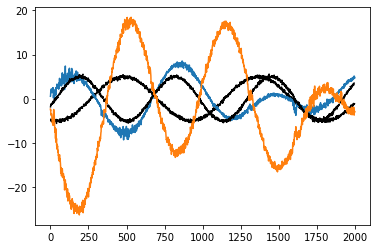

In [103]:
pyplot.plot(z.T[:,0], 'k--')
pyplot.plot(hssm.ks.smoothing_density.mu[:,0])
pyplot.plot(z.T[:,1], 'k--')
pyplot.plot(hssm.ks.smoothing_density.mu[:,1])

In [120]:
A = numpy.random.randn(5,3)
B = numpy.random.randn(4,3,3)
A2 = numpy.tile(A[None], [1, 1, 1])
C1 = numpy.einsum('abc,dc->abd', B, A)
C2 = numpy.einsum('abc,adc->abd', B, A2)

In [121]:
C1 == C2

array([[[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]]])

# Check W gradients

In [764]:
hssm = HeteroscedasticStateSpace_EM(X.T, Dz, Du=1, noise_x=1., noise_z=.01)
#hssm.W[0,:] = 0

In [765]:
hssm.estep()

In [766]:
hssm.update_W()

-17704.50787555687
      fun: 17704.50787555687
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.62099646e-06, -8.16416041e-06,  3.22964075e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 1
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-2.64741871e-06,  1.74869478e-04,  1.25558160e-04])


In [730]:
self = hssm
iu = 0
conv_crit = 1e-4
phi = self.ks.smoothing_density.slice(range(1,self.T+1))
w_i = self.W[1:,iu:iu+1].T
v = numpy.tile(w_i, (self.T, 1))
b_i = self.W[0,iu:iu+1]
u_i = self.U[:,iu:iu+1]
beta = self.beta[iu:iu+1]
uC = numpy.dot(u_i.T, -self.C)
ux_d = numpy.dot(u_i.T, self.ks.X.T-self.d[:,None])
# Lower bound for E[ln (sigma_x^2 + f(h))]
omega_dagger = numpy.sqrt(phi.integrate('Ax_aBx_b_inner', A_mat=w_i, a_vec=b_i,
                                                          B_mat=w_i, b_vec=b_i))
f_omega_dagger = self.f(omega_dagger, beta)
log_lb = numpy.log(self.sigma_x ** 2 + f_omega_dagger)
# Lower bound for E[f(h) / (sigma_x^2 + f(h)) * (u'epsilon(z))^2]
omega_star = numpy.ones(self.T)
converged = False
num_iter = 0
while not converged and num_iter < 10:
    # From the lower bound term
    g_omega = self.g(omega_star, beta)
    nu_plus = (1. - g_omega[:,None]) * (b_i * w_i)
    nu_minus = (-1. - g_omega[:,None]) * (b_i * w_i)
    ln_beta = - numpy.log(self.sigma_x ** 2 + self.f(omega_star, beta)) - .5 * g_omega * (b_i ** 2 - omega_star ** 2)+ numpy.log(beta)
    ln_beta_plus = ln_beta + b_i
    ln_beta_minus = ln_beta - b_i
    # Create OneRankFactors
    exp_factor_plus = factors.OneRankFactor(v=v, g=g_omega, nu=nu_plus, ln_beta=ln_beta_plus)
    exp_factor_minus = factors.OneRankFactor(v=v, g=g_omega, nu=nu_minus, ln_beta=ln_beta_minus)
    # Create the two measures
    exp_phi_plus = phi.hadamard(exp_factor_plus)
    exp_phi_minus = phi.hadamard(exp_factor_minus)
    # Fourth order integrals E[h^2 (x-Cz-d)^2]
    mat1 = uC
    vec1 = ux_d.T
    mat2 = w_i
    vec2 = b_i
    quart_int_plus = exp_phi_plus.integrate('Ax_aBx_bCx_cDx_d_inner', A_mat=mat1, a_vec=vec1, B_mat=mat1, b_vec=vec1, 
                                                                      C_mat=mat2, c_vec=vec2, D_mat=mat2, d_vec=vec2)
    quart_int_minus = exp_phi_minus.integrate('Ax_aBx_bCx_cDx_d_inner', A_mat=mat1, a_vec=vec1, B_mat=mat1, b_vec=vec1, 
                                                                      C_mat=mat2, c_vec=vec2, D_mat=mat2, d_vec=vec2)
    quart_int = quart_int_plus + quart_int_minus
    # Second order integrals E[(x-Cz-d)^2] Dims: [Du, Dx, Dx]
    quad_int_plus = exp_phi_plus.integrate('Ax_aBx_b_inner', A_mat=mat1, a_vec=vec1, B_mat=mat1, b_vec=vec1)
    quad_int_minus = exp_phi_plus.integrate('Ax_aBx_b_inner', A_mat=mat1, a_vec=vec1, B_mat=mat1, b_vec=vec1)
    quad_int = quad_int_plus + quad_int_minus
    omega_old = omega_star
    #omega_star = numpy.amin([numpy.amax([numpy.sqrt(quart_int / quad_int), 1e-10]), 1e2])
    #quad_int[quad_int < 1e-4] = 1e-4
    omega_star = numpy.sqrt(numpy.abs(quart_int / (quad_int+1e-10)))
    # For numerical stability
    omega_star[omega_star < 1e-4] = 1e-4
    omega_star[omega_star > 30] = 30
    #print(numpy.amax(numpy.abs(omega_star - omega_old)))
    converged = numpy.amax(numpy.abs(omega_star - omega_old)) < conv_crit
    num_iter += 1

In [762]:
mat1 = -self.C
vec1 = self.ks.X - self.d[None]
R_plus = exp_phi_plus.integrate('Ax_aBx_b_outer', A_mat=mat1, a_vec=vec1, B_mat=mat1, b_vec=vec1)
R_minus = exp_phi_minus.integrate('Ax_aBx_b_outer', A_mat=mat1, a_vec=vec1, B_mat=mat1, b_vec=vec1)
R = R_plus + R_minus
uRu = numpy.sum(u_i * numpy.dot(numpy.sum(R, axis=0), u_i))
log_lb_sum = numpy.sum(log_lb)

uRu = numpy.sum(u_i * numpy.dot(numpy.sum(R, axis=0), u_i))
##### w_i gradiend ######################################################################
# E[f'(h)exp(-k(h,omega^*)) dh/dw (u'epsilon(z))^2]
# Matrix and vector for dh/dw
dW = numpy.zeros((self.Dz + 1, self.Dz))
dW[1:] = numpy.eye(self.Dz)
db = numpy.zeros(self.Dz + 1)
db[0] = 1
dw_i = numpy.sum(exp_phi_plus.integrate('Ax_aBx_bCx_c_outer', A_mat=uC, a_vec=ux_d.T,
                                        B_mat=uC, b_vec=ux_d.T, C_mat=dW, c_vec=db), axis=0)
dw_i -= numpy.sum(exp_phi_minus.integrate('Ax_aBx_bCx_c_outer', A_mat=uC, a_vec=ux_d.T, 
                                          B_mat=uC, b_vec=ux_d.T, C_mat=dW, c_vec=db), axis=0)
# -g(omega) * E[f(h)exp(-k(h,omega^*)) h dh/dw (u'epsilon(z))^2]
dw_i -= numpy.einsum('a,ab->b', g_omega, exp_phi_plus.integrate('Ax_aBx_bCx_cDx_d_outer', A_mat=w_i, a_vec=b_i,
                                                                B_mat=uC, b_vec=ux_d.T, C_mat=uC, c_vec=ux_d.T,
                                                                D_mat=dW, d_vec=db)[:,0])
dw_i -= numpy.einsum('a,ab->b', g_omega, exp_phi_minus.integrate('Ax_aBx_bCx_cDx_d_outer', A_mat=w_i, a_vec=b_i,
                                                                 B_mat=uC, b_vec=ux_d.T, C_mat=uC, c_vec=ux_d.T,
                                                                 D_mat=dW, d_vec=db)[:,0])
dw_i /= self.sigma_x ** 2
# g(omega^+)E[h dh/dw]
dw_i -= numpy.einsum('a,ab->b', self.g(omega_dagger, beta), phi.integrate('Ax_aBx_b_outer', A_mat=w_i, a_vec=b_i, 
                                                                          B_mat=dW, b_vec=db)[:,0])
dw_i /= 2.
dw_i

array([ 0.00494667, -0.00904373, -0.01084746])

In [763]:
uRu, log_lb_sum, dw_i, dln_beta_i, dlnsigma2 = self.get_lb_i(iu, phi, update='gradients')
dw_i

array([ 0.00458681, -0.00905743, -0.01076159])

In [747]:
w0 = numpy.copy(self.W)
#w0[0,0] += 1e-4
w1 = numpy.copy(w0)
w1[0,0] += 1e-6

w_i0 = w0[1:,iu:iu+1].T
v0 = numpy.tile(w_i0, (self.T, 1))
b_i0 = w0[0,iu:iu+1]

w_i1 = w1[1:,iu:iu+1].T
v1 = numpy.tile(w_i1, (self.T, 1))
b_i1 = w1[0,iu:iu+1]


g_omega = self.g(omega_star, beta)
nu_plus = w_i0 - g_omega[:,None] * (b_i0 * w_i0)
nu_minus = - w_i0 - g_omega[:,None] * (b_i0 * w_i0)
ln_beta = - numpy.log(self.sigma_x ** 2 + self.f(omega_star, beta)) - .5 * g_omega * (b_i0 ** 2 - omega_star ** 2) + numpy.log(beta)
ln_beta_plus = ln_beta + b_i0
ln_beta_minus = ln_beta - b_i0
# Create OneRankFactors
exp_factor_plus = factors.OneRankFactor(v=v0, g=g_omega, nu=nu_plus, ln_beta=ln_beta_plus)
exp_factor_minus = factors.OneRankFactor(v=v0, g=g_omega, nu=nu_minus, ln_beta=ln_beta_minus)
# Create the two measures
exp_phi_plus = phi.hadamard(exp_factor_plus)
exp_phi_minus = phi.hadamard(exp_factor_minus)
mat1 = uC
vec1 = ux_d.T
quad_int_plus0 = exp_phi_plus.integrate('Ax_aBx_b_inner', A_mat=mat1, a_vec=vec1, B_mat=mat1, b_vec=vec1)
quad_int_minus0 = exp_phi_minus.integrate('Ax_aBx_b_inner', A_mat=mat1, a_vec=vec1, B_mat=mat1, b_vec=vec1)
Qm0 = numpy.sum(quad_int_plus0 + quad_int_minus0)


g_omega = self.g(omega_star, beta)
nu_plus = 1. * w_i1 - g_omega[:,None] * (b_i1 * w_i1)
nu_minus = -1. * w_i1 - g_omega[:,None] * (b_i1 * w_i1)
ln_beta = - numpy.log(self.sigma_x ** 2 + self.f(omega_star, beta)) - .5 * g_omega * (b_i1 ** 2 - omega_star ** 2) + numpy.log(beta)
ln_beta_plus = ln_beta + b_i1
ln_beta_minus = ln_beta - b_i1
# Create OneRankFactors
exp_factor_plus = factors.OneRankFactor(v=v1, g=g_omega, nu=nu_plus, ln_beta=ln_beta_plus)
exp_factor_minus = factors.OneRankFactor(v=v1, g=g_omega, nu=nu_minus, ln_beta=ln_beta_minus)
# Create the two measures
exp_phi_plus = phi.hadamard(exp_factor_plus)
exp_phi_minus = phi.hadamard(exp_factor_minus)
mat1 = uC
vec1 = ux_d.T
quad_int_plus1 = exp_phi_plus.integrate('Ax_aBx_b_inner', A_mat=mat1, a_vec=vec1, B_mat=mat1, b_vec=vec1)
quad_int_minus1 = exp_phi_minus.integrate('Ax_aBx_b_inner', A_mat=mat1, a_vec=vec1, B_mat=mat1, b_vec=vec1)
Qm1 = numpy.sum(quad_int_plus1 + quad_int_minus1)

In [758]:
(Qm1 - Qm0) / 1e-6

0.01844205144152511

In [759]:
dw_i

array([ 0.01813861, -0.04127512, -0.03322448])

In [760]:
dW = numpy.zeros((self.Dz + 1, self.Dz))
dW[1:] = numpy.eye(self.Dz)
db = numpy.zeros(self.Dz + 1)
db[0] = 1

dw_i = -numpy.sum(exp_phi_plus.integrate('Ax_aBx_bCx_c_outer', A_mat=uC, a_vec=ux_d.T,
                                        B_mat=uC, b_vec=ux_d.T, C_mat=dW, c_vec=db), axis=0)
dw_i += numpy.sum(exp_phi_minus.integrate('Ax_aBx_bCx_c_outer', A_mat=uC, a_vec=ux_d.T, 
                                          B_mat=uC, b_vec=ux_d.T, C_mat=dW, c_vec=db), axis=0)
dw_i

array([-0.02248606,  0.04950275,  0.0400411 ])

In [645]:
quad_int_plus = exp_phi_plus.integrate('Ax_aBx_b_inner', A_mat=uC, a_vec=ux_d, B_mat=uC, b_vec=ux_d)
quad_int_minus = exp_phi_minus.integrate('Ax_aBx_b_inner', A_mat=uC, a_vec=ux_d, B_mat=uC, b_vec=ux_d)
numpy.sum(quad_int_plus - quad_int_minus)

17.756438662642267

In [628]:
exp_phi_plus.integrate('Ax_aBx_bCx_cDx_d_outer', A_mat=w_i, a_vec=b_i,
                                                                B_mat=uC, b_vec=ux_d.T, C_mat=uC, c_vec=ux_d.T,
                                                                D_mat=dW, d_vec=db).shape

(2000, 1, 3)

In [602]:
dw_i = numpy.einsum('a,ab->b', g_omega, exp_phi_plus.integrate('Ax_aBx_bCx_cDx_d_outer', A_mat=w_i, a_vec=b_i,
                                                                B_mat=uC, b_vec=ux_d.T, C_mat=uC, c_vec=ux_d.T,
                                                                D_mat=dW, d_vec=db)[:,0])
dw_i += numpy.einsum('a,ab->b', g_omega, exp_phi_minus.integrate('Ax_aBx_bCx_cDx_d_outer', A_mat=w_i, a_vec=b_i,
                                                                 B_mat=uC, b_vec=ux_d.T, C_mat=uC, c_vec=ux_d.T,
                                                                 D_mat=dW, d_vec=db)[:,0])
dw_i

array([0.00034984, 0.00184957, 0.00233279])

In [642]:
g_omega = self.g(omega_star, beta)
nu_plus = 1. * w_i - g_omega[:,None] * (b_i * w_i)
nu_minus = -1.* w_i - g_omega[:,None] * (b_i * w_i)
ln_beta = - numpy.log(self.sigma_x ** 2 + self.f(omega_star, beta)) - .5 * g_omega * (b_i ** 2 - omega_star ** 2) + numpy.log(beta)
ln_beta_plus = ln_beta + b_i
ln_beta_minus = ln_beta - b_i
# Create OneRankFactors
exp_factor_plus = factors.OneRankFactor(v=v, g=g_omega, nu=nu_plus, ln_beta=ln_beta_plus)
exp_factor_minus = factors.OneRankFactor(v=v, g=g_omega, nu=nu_minus, ln_beta=ln_beta_minus)
# Create the two measures
exp_phi_plus = phi.hadamard(exp_factor_plus)
exp_phi_minus = phi.hadamard(exp_factor_minus)
mat1 = uC
vec1 = ux_d
quad_int_plus = exp_phi_plus.integrate('Ax_aBx_b_inner', A_mat=mat1, a_vec=vec1, B_mat=mat1, b_vec=vec1)
quad_int_minus = exp_phi_minus.integrate('Ax_aBx_b_inner', A_mat=mat1, a_vec=vec1, B_mat=mat1, b_vec=vec1)

In [643]:
numpy.sum(quad_int_plus - quad_int_minus)

17.756438662642267

In [517]:
numpy.sum(exp_phi_plus.integrate('Ax_aBx_bCx_c_outer', A_mat=uC, a_vec=ux_d.T, B_mat=uC, b_vec=ux_d.T, C_mat=dW, c_vec=db), axis=0)- numpy.sum(exp_phi_minus.integrate('Ax_aBx_bCx_c_outer', A_mat=uC, a_vec=ux_d.T, B_mat=uC, b_vec=ux_d.T, C_mat=dW, c_vec=db), axis=0)

array([0.00210524, 0.0110976 , 0.01399624])

In [597]:
dw_i

array([-0.00209918, -0.01109962, -0.01400019])

In [519]:
dw_i = numpy.einsum('a,ab->b', g_omega, exp_phi_plus.integrate('Ax_aBx_bCx_cDx_d_outer', A_mat=w_i, a_vec=b_i,
                                                                B_mat=uC, b_vec=ux_d.T, C_mat=uC, c_vec=ux_d.T,
                                                                D_mat=dW, d_vec=db)[:,0])
dw_i += numpy.einsum('a,ab->b', g_omega, exp_phi_minus.integrate('Ax_aBx_bCx_cDx_d_outer', A_mat=w_i, a_vec=b_i,
                                                                 B_mat=uC, b_vec=ux_d.T, C_mat=uC, c_vec=ux_d.T,
                                                                 D_mat=dW, d_vec=db)[:,0])

In [521]:
dw_i

array([0.00034984, 0.00184957, 0.00233279])